# Time series in Pastas
*R.A. Collenteur, University of Graz, 2020*

Time series are at the heart of time series analysis, and therefore need to be considered carefully when dealing with time series models. In this notebook more background information is provided on important characteristics of time series and how these may influence your modeling results. In general, Pastas depends heavily on Pandas for dealing with time series, but adds capabilities to deal with irregular time series and missing data.

All time series should be provided to Pastas as `pandas.Series` with a `pandas.DatetimeIndex`. Internally these time series are stored in a `pastas.TimeSeries` object. The goal of this object is to validate the user-provided time series and enable resampling (changing frequencies) of the independent time series. The TimeSeries object also has  capabilities to deal with missing data in the user-provided time series. As much of these operations occur internally, this notebook is meant to explain users what is happening and how to check for this.

<div class="alert alert-info">

<b>Note</b>
    
* The standard Pastas data type for a date is the `pandas.Timestamp`.
* The standard Pastas data type for a sequence of dates is the `pandas.DatetimeIndex` with `pandas.Timestamp`.
* The standard  Pastas data type for a time series is a `pandas.Series` with a `pandas.DatetimeIndex`
    
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps

ps.show_versions()

Python version: 3.8.2 (default, Mar 25 2020, 11:22:43) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version: 1.21.2
Scipy version: 1.7.1
Pandas version: 1.3.3
Pastas version: 0.19.0b
Matplotlib version: 3.4.3


## Different types of time series
Time series data may generally be defined as a set of data values observed at certain times, ordered in a way that the time indices are increasing. Many time series analysis method assume that the time step between the observations is regular, the time series has evenly-spaced observations. These evenly spaced time series may have missing data, but it will still be possible to lay the values on a time-grid with constant time steps. 

This is generally also assumed to be the case for the independent time series in hydrological studies. For example, the precipitation records may have some missing data but the precipitation is reported as the total rainfall over one day. In the case of missing data, we may impute a zero (no rain) or the rainfall amount from a nearby measurement station.

Groundwater level time series do generally not share these characteristics with other hydrological time series, and are measured at irregular time intervals. This is especially true for historic time series that were measured by hand. The result is that the measurements can not be laid on a regular time grid. The figure below graphically shows the difference between the three types of time series.

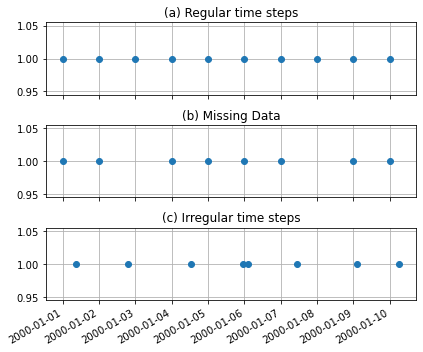

In [2]:
regular = pd.Series(index=pd.date_range("2000-01-01", "2000-01-10", freq="D"),
                   data=np.ones(10))
missing_data = regular.copy()
missing_data.loc[["2000-01-03", "2000-01-08"]] = np.nan

index = [t + pd.Timedelta(np.random.rand()*24, unit="H") for t in missing_data.index]
irregular = missing_data.copy()
irregular.index = index

fig, axes = plt.subplots(3,1, figsize=(6, 5), sharex=True, sharey=True)

regular.plot(ax=axes[0], linestyle=" ", marker="o", x_compat=True)
missing_data.plot(ax=axes[1], linestyle=" ", marker="o", x_compat=True)
irregular.plot(ax=axes[2], linestyle=" ", marker="o", x_compat=True)

for i, name in enumerate(["(a) Regular time steps", "(b) Missing Data", "(c) Irregular time steps"]):
    axes[i].grid()
    axes[i].set_title(name)
plt.tight_layout()

## Independent and dependent time series 
We can differentiate between two types of input time series for Pastas models: the dependent and independent time series. The dependent time series are those that we want to explain (e.g., the groundwater levels) and the independent time series are those that we use to explain the dependent time series (e.g., precipitation or evaporation). The requirements for these time series are different:

- The dependent time series may be of any kind: regular, missing data or irregular.
- The independent time series has to have regular time steps.

In practice, this means that the time series provided to `pastas.Model` may be of any kind, and that the time series used by the stressmodels (e.g., `pastas.RerchargeModel`) need to have regular time steps. The regular time steps  are required to simulate contributions to the groundwater level fluctuations. As there are virtually no restrictions on the dependent time series, the remainder of this notebook will discuss primarily the independent time series.

## How does the TimeSeries object validate a time series?
To ensure that a time series can be used for simulation a number of things are checked and changed:

1. Make sure the values are floats. Values are change to dtype=float if not.
2. Make sure the index is a `pandas.DatetimeIndex`. Index is changed if not.
3. Make sure the timestamps in the index are increasing. Index is sorted if not.
4. Make sure there are no nan-values at the start and end of a time series.
5. Determine the frequency of the time series.
6. Make sure there are no duplicate indices. Values are averaged if this is the case.
7. Remove or fill up nan-values, depending on the settings.

For each of these steps an INFO message will be returned by Pastas to inform the user if a change is made. The first four steps generally do not have a large impact and are there to prevent some basic issues. Preferably, no changes are reported. 

### Frequency of the input data
Pastas tries to determine the frequency in step 5, and will **always** report the result. It is generally good practice to double-check if the reported frequency agrees with what you know about the time series. Pastas will also report if no frequency can be inferred. If no frequency is reported there is probably some wrong and the user should fix either fix the input time series or provide Pastas with more information.

Below we consider a time series with precipitation data, measured every day. We will use `settings="prec` as a shortcut for the settings to fill nans and resample. We will come back to those settings later.

In [3]:
rain = pd.read_csv('../examples/data/rain_nb1.csv', parse_dates=['date'],
                     index_col='date').squeeze()
ps.TimeSeries(rain, settings="prec")

INFO: Inferred frequency for time series rain: freq=D


TimeSeries(name=rain, freq=None, freq_original=D, tmin=1980-01-01 00:00:00, tmax=2016-10-31 00:00:00)

Pastas correctly report the frequency and we can continue with this time series. Note that the input time series thus agrees with all the checks for the time series validation. Let's now introduce a nan-value and see what happens.

In [4]:
rain["1989-01-01"] = np.nan
ps.TimeSeries(rain, settings="prec")

INFO: Inferred frequency for time series rain: freq=D
INFO: Time Series rain: 1 nan-value(s) was/were found and filled with: 0.0.


TimeSeries(name=rain, freq=None, freq_original=D, tmin=1980-01-01 00:00:00, tmax=2016-10-31 00:00:00)

This also works fine. The frequency was inferred (stored as freq_original) and one nan-value was filled up with 0.0. Now we take the same time series, but drop the nan-value.

In [5]:
ps.TimeSeries(rain.dropna(), settings="prec")

INFO: Cannot determine frequency of series rain: freq=None. Resample settings are ignored and timestep_weighted_resample is used.


TimeSeries(name=rain, freq=None, freq_original=None, tmin=1980-01-01 00:00:00, tmax=2016-10-31 00:00:00)

The above result is probably not what we want. Pastas could not infer the frequency and therefore resorts to the `timestep_weighted_resample` method. Documentation for this method is available in utils.py.

If we know the original frequency of the time series, we can tell this to Pastas through the `freq_original` argument. As we can see below, the user-provided frequency is used.

In [6]:
rain = pd.read_csv('../examples/data/rain_nb1.csv', parse_dates=['date'],
                     index_col='date').squeeze()
rain["1989-01-01"] = np.nan
ps.TimeSeries(rain.dropna(), settings="prec", freq_original="D")

INFO: User provided frequency for time series rain: freq=D
INFO: Time Series rain: 1 nan-value(s) was/were found and filled with: 0.0.


TimeSeries(name=rain, freq=None, freq_original=D, tmin=1980-01-01 00:00:00, tmax=2016-10-31 00:00:00)

The above example shows how to obtain the same or different result with four different methods. Some of these methods requires good knowledge about the TimeSeries object and how it processes your time series. It is often preferred to provide Pastas with a better initial time series by resampling it yourself. This has the additional benefit that you are interacting more closely with the data. Most of the examples also follow this pattern.

<div class="alert alert-info">

<b>Best practice</b>

Try and modify your original time series such that Pastas returns a message that it was able to infer the frequency from the time series itself: **INFO: Inferred frequency for time series rain: freq=D**
    
</div>

## Time series settings
In the examples above we used the `settings` keyword when creating the TimeSeries. This is a shortcut method to select a number of settings from a predefined set of options. These predefined options can accessed through `ps.rcParams["timeseries"]`:

In [7]:
pd.DataFrame.from_dict(ps.rcParams["timeseries"])

,oseries,prec,evap,well,waterlevel,level,flux,quantity
fill_nan,drop,0.0,interpolate,0.0,interpolate,interpolate,0.0,0.0
sample_down,drop,mean,mean,mean,mean,mean,mean,sum
sample_up,NaN,bfill,bfill,bfill,interpolate,interpolate,bfill,divide
fill_before,NaN,mean,mean,0.0,mean,mean,mean,mean
fill_after,NaN,mean,mean,0.0,mean,mean,mean,mean


Each column name is a valid option for the `settings` argument. The rows shows the settings that may be chosen for changing the original time series. Once a TimeSeries is created, we can access the existing settings as follows:

In [8]:
ts = ps.TimeSeries(rain, settings="prec")
ts.settings

INFO: Inferred frequency for time series rain: freq=D
INFO: Time Series rain: 1 nan-value(s) was/were found and filled with: 0.0.


{'freq': None,
 'sample_up': 'bfill',
 'sample_down': 'mean',
 'fill_nan': 0.0,
 'fill_before': 'mean',
 'fill_after': 'mean',
 'tmin': Timestamp('1980-01-01 00:00:00', freq='D'),
 'tmax': Timestamp('2016-10-31 00:00:00', freq='D'),
 'norm': None,
 'time_offset': Timedelta('0 days 00:00:00')}

This settings dictionary now includes both settings used to resample (sample_up, sample_down), extend (fill_before, fill_after), normalize (norm), and fill nans in the time series, but also dynamic settings such as the start and end date (tmin, tmax), the frequency (freq) and the time offset. 

To update these settings you the `update_series` method is available. For example, if we want to resample the above time series to a 7-day frequency and sum up the values we can use:

In [9]:
ts.update_series(freq="7D", sample_down="sum")

INFO: Time Series rain was sampled down to freq 7D with method sum.
INFO: Time Series rain was extended to 1980-01-01 00:00:00 with the mean value of the time series.


Because the original series are stored in the TimeSeries object as well, it is also possible to go back again. The changing made to the time series are always started from the original validated time series again. For more information on the possible settings see the API-docs for the [TimeSeries and update_series method](https://pastas.readthedocs.io/en/latest/api/timeseries.html) on the documentation website.

## An example with a Pastas Model
By now you may be wondering why all these settings exist in the first place. The main reason (apart from validating the user-provided time series) is to change the time step of the simulation of the independent time series. It may also be used to extend the time series in time.

Below we load some time series, visualize them and create a Pastas model with precipitation and evaporation to explain the groundwater level fluctuations. It is generally recommended to plot your time series for a quick visual check of the input data.

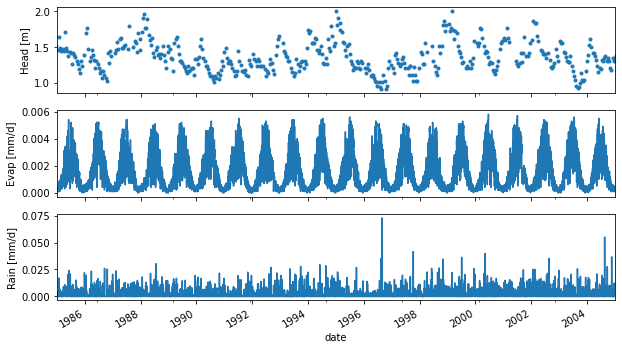

In [10]:
head = pd.read_csv("../examples/data/B32C0639001.csv",  parse_dates=['date'], 
                   index_col='date').squeeze()
rain = pd.read_csv('../examples/data/rain_nb1.csv', parse_dates=['date'],
                     index_col='date').squeeze()
evap = pd.read_csv('../examples/data/evap_nb1.csv', parse_dates=['date'],
                   index_col='date').squeeze()

fig, axes = plt.subplots(3,1, figsize=(10,6), sharex=True)
head.plot(ax=axes[0], x_compat=True, linestyle=" ", marker=".")
evap.plot(ax=axes[1], x_compat=True)
rain.plot(ax=axes[2], x_compat=True)
axes[0].set_ylabel("Head [m]")
axes[1].set_ylabel("Evap [mm/d]")
axes[2].set_ylabel("Rain [mm/d]")

plt.xlim("1985", "2005");

In [11]:
ml = ps.Model(head)

rch = ps.rch.Linear()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma, name="rch")
ml.add_stressmodel(rm)

ml.solve(noise=True, tmin="1990", report="basic")

INFO: Cannot determine frequency of series head: freq=None. The time series is irregular.
INFO: Inferred frequency for time series rain: freq=D
INFO: Inferred frequency for time series evap: freq=D


Fit report head                     Fit Statistics
nfev    30                     EVP           70.97
nobs    351                    R2             0.71
noise   True                   RMSE           0.11
tmin    1990-01-01 00:00:00    AIC        -1809.18
tmax    2005-10-14 00:00:00    BIC        -1786.01
freq    D                      Obj            0.98
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr     initial  vary
rch_A        310.205373  ±10.67%  215.674528  True
rch_n          0.921110   ±3.43%    1.000000  True
rch_a        132.157546  ±16.41%   10.000000  True
rch_f         -0.619843  ±12.21%   -1.000000  True
constant_d     1.019627   ±5.74%    1.359779  True
noise_alpha   53.173175  ±13.15%   15.000000  True


## What is the model freq?
The output below shows that the time series have frequencies of `freq=D`. The fit report also shows a frequency of `freq=D`. The frequency reported in the fit_report is the time step of the simulation for the independent time series, and is internally passed on to the stressmodels. The user-provided dependent time series are stored in the stressmodel object and can be accessed as follows. 

In [12]:
ml.stressmodels["rch"].stress

[TimeSeries(name=rain, freq=D, freq_original=D, tmin=1980-01-04 00:00:00, tmax=2005-10-14 00:00:00),
 TimeSeries(name=evap, freq=D, freq_original=D, tmin=1980-01-04 00:00:00, tmax=2005-10-14 00:00:00)]

If we want to change the resample method, for example we want to sum the precipitation and evaporation when sampling down (e.g., daily to weekly) we may do the following:

In [13]:
for stress in ml.stressmodels["rch"].stress:
    stress.update_series(sample_down="sum")

After changing the methods for sampling down, we now solve the model with a simulation time step of 14 days. The precipitation and evaporation are then summed up over 14 day intervals, before being translated to a groundwater fluctuation using a respons function.

In [14]:
ml.settings

{'tmin': Timestamp('1990-01-01 00:00:00'),
 'tmax': Timestamp('2005-10-14 00:00:00'),
 'freq': 'D',
 'warmup': Timedelta('3650 days 00:00:00'),
 'time_offset': Timedelta('0 days 00:00:00'),
 'noise': True,
 'solver': 'LeastSquares',
 'fit_constant': True,
 'weights': None}

INFO: Time Series rain was sampled down to freq 14D with method sum.
INFO: Time Series rain was extended to 1971-07-01 00:00:00 with the mean value of the time series.
INFO: Time Series evap was sampled down to freq 14D with method sum.
INFO: Time Series evap was extended to 1971-07-01 00:00:00 with the mean value of the time series.
INFO: There are observations between the simulation timesteps. Linear interpolation between simulated values is used.
INFO: Time Series rain was sampled down to freq 14D with method sum.
INFO: Time Series rain was extended to 1959-12-31 00:00:00 with the mean value of the time series.
INFO: Time Series evap was sampled down to freq 14D with method sum.
INFO: Time Series evap was extended to 1959-12-31 00:00:00 with the mean value of the time series.


Fit report head                     Fit Statistics
nfev    36                     EVP           69.29
nobs    539                    R2             0.69
noise   True                   RMSE           0.11
tmin    1981-07-03 00:00:00    AIC        -2690.00
tmax    2005-10-14 00:00:00    BIC        -2664.26
freq    14D                    Obj            1.79
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.         Yes

Parameters (6 optimized)
                optimal   stderr     initial  vary
rch_A         26.219636  ±13.56%  215.674528  True
rch_n          0.741206   ±6.07%    1.000000  True
rch_a        258.921048  ±30.14%   10.000000  True
rch_f         -0.745625  ±13.10%   -1.000000  True
constant_d     1.045195   ±7.05%    1.359779  True
noise_alpha   44.882159  ±12.43%   15.000000  True


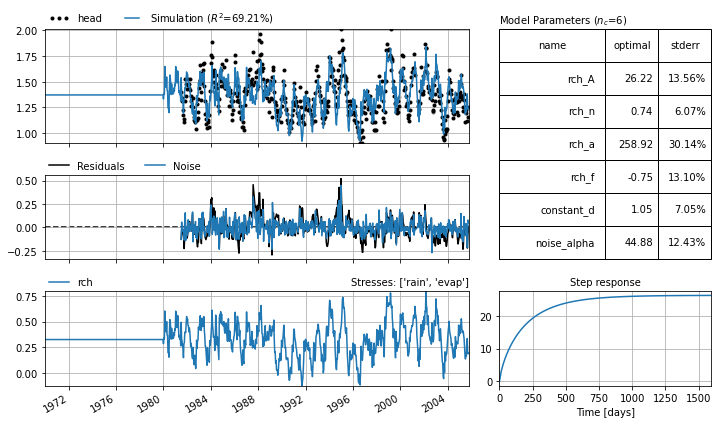

In [15]:
ml.solve(freq="14D", tmin="1980", report="basic")
ml.plots.results(figsize=(10,6), tmin="1970");

In [16]:
ml.stressmodels["rch"].stress[1].update_series(tmin="1960")
ml.stressmodels["rch"].stress[1].settings

INFO: Time Series evap was sampled down to freq 14D with method sum.
INFO: Time Series evap was extended to 1960-01-01 00:00:00 with the mean value of the time series.


{'freq': '14D',
 'sample_up': 'bfill',
 'sample_down': 'sum',
 'fill_nan': 'interpolate',
 'fill_before': 'mean',
 'fill_after': 'mean',
 'tmin': Timestamp('1960-01-01 00:00:00'),
 'tmax': Timestamp('2005-10-14 00:00:00'),
 'norm': None,
 'time_offset': Timedelta('1 days 00:00:00')}

Another method to obtain the settings of the time series used in a stressmodel is as follows:

In [17]:
ml.get_stressmodel_settings("rch")

{'rain': {'freq': '14D',
  'sample_up': 'bfill',
  'sample_down': 'sum',
  'fill_nan': 0.0,
  'fill_before': 'mean',
  'fill_after': 'mean',
  'tmin': Timestamp('1959-12-31 00:00:00', freq='14D'),
  'tmax': Timestamp('2005-10-14 00:00:00'),
  'norm': None,
  'time_offset': Timedelta('0 days 00:00:00')},
 'evap': {'freq': '14D',
  'sample_up': 'bfill',
  'sample_down': 'sum',
  'fill_nan': 'interpolate',
  'fill_before': 'mean',
  'fill_after': 'mean',
  'tmin': Timestamp('1960-01-01 00:00:00'),
  'tmax': Timestamp('2005-10-14 00:00:00'),
  'norm': None,
  'time_offset': Timedelta('1 days 00:00:00')}}

## Warnings
Because the TimeSeries object is a relatively complicated object that can potentially change model results extra care has to be taken in some cases. Below is a number of outstanding warnings and the related GitHub issues. 

<div class="alert alert-warning">

<b>A note on dependent time series</b>

The dependent time series (stored as `ml.oseries`) are also stored in a TimeSeries object and therefore have the same capabilities. Usage of these methods on the dependent time series is however experimental and not recommended for real world use cases. See also [Issue #68](https://github.com/pastas/pastas/issues/68) and [Discussion #199](https://github.com/pastas/pastas/discussions/199)
    
</div>


<div class="alert alert-warning">

<b>A note on monthly data</b>

Monthly data is strictly irregular data, and poses additional challenges when resampling to regular frequencies. Pastas does not differentiate between monthly data reported at months end (`freq=M`) or months beginning (`freq=MS`) and the default settings are selected for `freq=M`. There may also be issues with extending the time series. See also [Issue #239](https://github.com/pastas/pastas/issues/239)
    
</div>